<a href="https://colab.research.google.com/github/thinkGrow/Neural-Network-CSC424/blob/main/nn_3c_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt     
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import math

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
x_temp_train = trainset.data
x_test = testset.data
y_temp_train = np.array(trainset.targets)
y_test = np.array(testset.targets)

x_temp_train = x_temp_train/255 #50,000*32*32*3
x_test = x_test/255

no_of_samples = 50000

x_train = np.zeros((no_of_samples,32,32,3))
y_train = np.zeros((no_of_samples))

for i in range(no_of_samples):
    x_train[i] = x_temp_train[i]
    y_train[i] = y_temp_train[i]

no_of_train_sample = x_train.shape[0]
no_of_train_sample
print(y_train.shape)

(50000,)


In [ ]:
#reshaping
x_train = x_train.reshape(no_of_train_sample, 3072) #50,000 x 3072
x_test = x_test.reshape(x_test.shape[0], 3072) #10000 x 3072
y_train = y_train.reshape(no_of_train_sample,1)
y_test = y_test.reshape(10000,1)

In [ ]:
def sigmoid(x):
    x = np.clip(x, -80, 100)
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return x*(1-x)

def softmax(A):
    A = np.clip(A, -100, 80)
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

def xavier_initializer(fan_in, fan_out) :
    limit = math.sqrt(6/(fan_in + fan_out))

    fan_in_o = 4000
    fan_out_o = 1
    limit_o = math.sqrt(6/(fan_in_o + fan_out_o))

    return np.random.uniform(-limit, limit, size=(fan_in, fan_out)) 

def ohe(to_encode):
    ohe = np.zeros((to_encode.shape[0],10))
    for i in range(to_encode.shape[0]):
        for j in range(10):
            if to_encode[i] == j:
                ohe[i][j] = 1 
    return ohe

In [ ]:
y_train_ohe = ohe(y_train)
y_test_ohe = ohe(y_test)

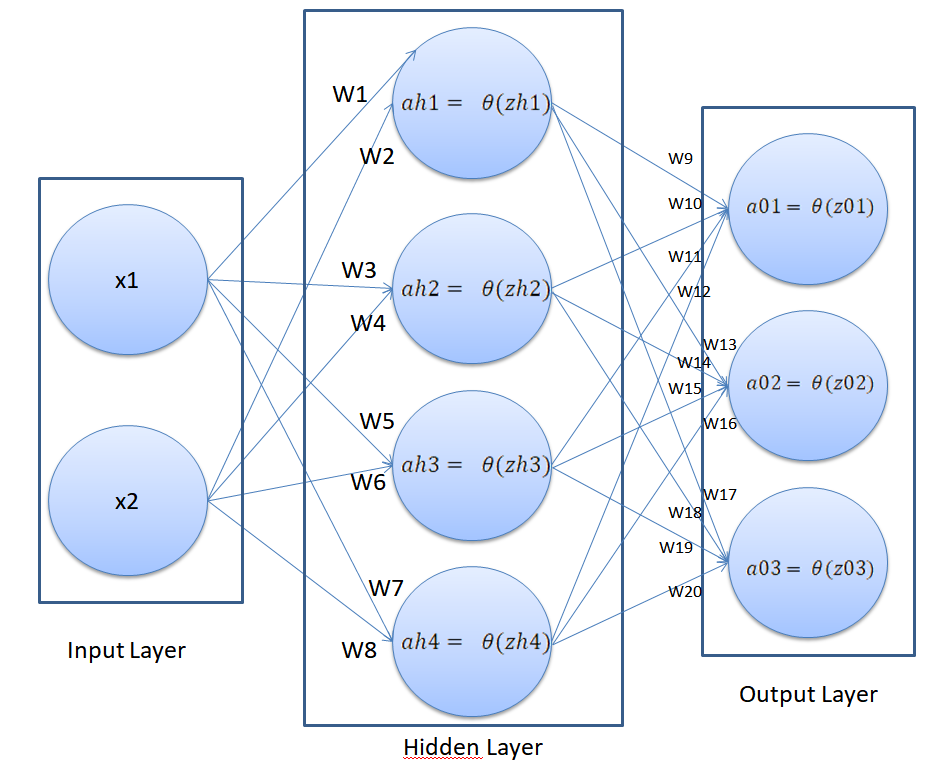

In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.w1 = xavier_initializer(3072,4000)
        # self.w1 = np.random.rand(3072,4000)
        self.b1 = np.random.randn(4000)

        self.w2 = xavier_initializer(4000,4000)
        self.b2 = np.random.randn(4000)

        self.w3 = xavier_initializer(4000,10)
        self.b3 = np.random.randn(10)

        self.lr = 0.001

        self.z1 = np.empty((1000,4000))
        self.a1 = np.empty((1000,4000))

        self.z2 = np.empty(1)
        self.a2 = np.empty(1)

        self.z3 = np.empty(1)
        self.a3 = np.empty(1)

        self.loss_epoch_temp = 0

        self.batch_size = 1000
    
    def feedforward(self, x_batch):
        # Phase 1
        self.z1 = np.dot(x_batch, self.w1) + self.b1
        self.a1 = sigmoid(self.z1)

        # Phase 2
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(self.z2)

        # Phase 3
        self.z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = softmax(self.z3)

        return self.a3


    def backprop(self, x_batch, y_batch):
        ## Back Propagation
        
        #Phase 1
        # dL_da3 = y_train/a3
        # da3_dz3 = softmax_der(z3)
        dL_dz3 = self.a3 - y_batch 
        dz3_dw3 = self.a2
        dL_w3 = np.dot(dz3_dw3.T, dL_dz3)

        dL_db3 = np.sum(dL_dz3, axis=0, keepdims=True)

        #Phase 2
        dz2_dw2 = self.a1

        da2_dz2 = sigmoid_der(self.a2)

        dz3_da2 = self.w3
        # dL_dz3 = dL_da3 * da3_dz3

        dL_da2 = np.dot(dL_dz3, dz3_da2.T )
        # dL_da2 = dL_dz3 * dz3_da2.T #(1000,10) (4000,10)
        prod = da2_dz2 * dL_da2
        dL_w2 = np.dot(dz2_dw2.T, da2_dz2 * dL_da2)
        
        # dL_dz2 = dL_da2 * da2_dz2
        dL_dz2 = prod
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        # dL_db2 = dL_da2 * da2_dz2

        #Phase 3
        dz1_dw1 = x_batch

        da1_dz1 = sigmoid_der(self.a1)

        dz2_da1 = self.w2
        
        dL_da1 = np.dot(dL_dz2, dz2_da1.T)
        # dL_da1 = dL_dz2 * dz2_da1   #(1000,4000) (4000,4000) 

        prod_2 = da1_dz1*dL_da1
        # dL_w1 = np.dot(dz1_dw1.T, da1_dz1*dL_da1)
        dL_w1 = np.dot(dz1_dw1.T, prod_2)

        # dL_db1 = dL_da1 * da1_dz1
        # dL_dz1 = dL_da1 * da1_dz1
        dL_dz1 = prod
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        # Update Weights 

        self.w1 -= self.lr * dL_w1
        self.b1 -= self.lr * dL_db1.sum(axis=0)

        self.w2 -= self.lr * dL_w2
        self.b2 -= self.lr * dL_db2.sum(axis=0)

        self.w3 -= self.lr * dL_w3
        self.b3 -= self.lr * dL_db3.sum(axis=0)

        
        loss = np.sum(-y_batch * np.log(self.a3))
        loss = loss.item()
        # print('Loss of batch ', i, ': ',  loss)
        self.loss_epoch_temp += loss



    def train(self, x_train, y_train) :
        loss = 0.0
        for epoch in range(10):
            i = 0
            j = self.batch_size

            for k in range(no_of_train_sample//self.batch_size):
                x_batch = x_train[i:j,:]
                y_batch = y_train[i:j,:]
                i += self.batch_size
                j += self.batch_size

                self.feedforward(x_batch)
                self.backprop(x_batch,y_batch)

            print(f'epoch no. {epoch+1} : {self.loss_epoch_temp}') 
            self.loss_epoch_temp = 0

In [ ]:
nn = NeuralNetwork()
nn.train(x_train, y_train_ohe)
y_predict = nn.feedforward(x_test)

epoch no. 1 : 211208.9566170917
epoch no. 2 : 114741.88926297589
epoch no. 3 : 114269.08495580303
epoch no. 4 : 114058.06335168034
epoch no. 5 : 112092.76155238299
epoch no. 6 : 109756.44203485175
epoch no. 7 : 107032.03532453568
epoch no. 8 : 104887.57415871174
epoch no. 9 : 103272.05949770722
epoch no. 10 : 101447.31936483864


In [ ]:
index = np.argmax(y_predict, axis=1)
y_predict_ohe = np.zeros((10000,10))
for i in range(10000):    
    for j in range(10):
        if j == index[i]:
              y_predict_ohe[i][index[i]]= 1
        else: y_predict_ohe[i][j]=0 

In [ ]:
#Accuracy
import pandas as pd
from sklearn.metrics import accuracy_score

print(f'Accuracy : { accuracy_score(y_test_ohe, y_predict_ohe)}' )

Accuracy : 0.2244


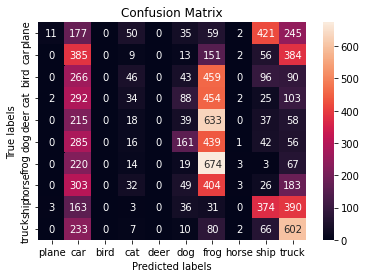

In [ ]:
#Confusion Matrix for multi-class
import seaborn as sns
from sklearn.metrics import confusion_matrix

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']   

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_test_ohe).argmax(axis=1), np.asarray(y_predict_ohe).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);